# 生成对抗网络

生成对抗网络（GAN）于2014年由Ian Goodfellow提出，理念清晰而优秀，但训练上有一些问题，存在一些困难难以克服，使得GAN更迭了多个版本。

原始的GAN损失函数（从上到下分别为判别器和生成器的损失函数）为：
$$
L_D^{GAN} = E[\log(D(x))] + E[\log(1-D(G(z))]\\
L_G^{GAN} = E[\log(D(G(z))]
$$

一个GAN分为两部分：**生成器、判别器**。生成器试图生成尽可能真的数据，判别器尽可能辨别出真数据和假数据。生成器的功能有点类似自编码器中的编码器，但训练起来比较困难；

![GAN图示](../imgs/gan.png)

# 1. GAN的训练

GAN的每个训练迭代分为两阶段：

1. 第一阶段训练的是**判别器**；从训练集中采样中一组真实样本，并通过生成器产生相同数量的生成样本，真实样本和生成样本给定不同的标签，然后训练判别器，由于就是一个二分类问题，损失函数选用的是二元交叉熵。此阶段的训练只训练判别器，即只更新判别器的权重，而固定生成器的权重。

2. 第二阶段训练的是**生成器**；首先产生另外一组生成样本，然后使用判别器进行判别样本真实性（所有的训练数据都是生成样本）。此时固定判别器权重，只更新生成器权重。

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

In [3]:
for i in range(len(physical_devices)):
    tf.config.experimental.set_memory_growth(physical_devices[i], True)

依旧选用的是Fashion MNIST数据集，数据格式可通过`keras.datasets.fashion_mnist.load_data?`查看

In [4]:
%matplotlib inline

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [6]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

## 1.1 模型构造

In [7]:
codings_size = 30

In [8]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[codings_size]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation='selu'),
    keras.layers.Dense(100, activation='selu'),
    keras.layers.Dense(1, activation='sigmoid')
])

gan = keras.models.Sequential([generator, discriminator])

## 1.2 模型编译

在训练时判别器时，输入数据是生成器的输出，但是生成器的权重不更新，做法是利用代码中的`gan`，但是冻结`discriminator`中的权重；训练生成器时，只需要利用到`generator`。

In [9]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

## 1.3 构建数据管道

In [10]:
def preprocess(data):
    return tf.cast(data, tf.float32) / 255

In [11]:
x_train = preprocess(x_train)
y_train = preprocess(y_train)
x_test = preprocess(x_test)
y_test = preprocess(y_test)

In [12]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000)
# 最后一个剩余batch剔除掉
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

## 1.4 训练GAN

GAN训练不同于此前模型，训练流程会略复杂一些，通过自定义训练循环进行训练

In [13]:
gan.layers

In [14]:
def plot_multiple_images(images, n_cols):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for inx, image in enumerate(images):
        plt.subplot(n_rows, n_cols, inx+1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

In [17]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=10):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        for batch in dataset:
            # generator输入为高斯噪声
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_data = generator(noise)
            fake_and_real_data = tf.concat([generated_data, batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(fake_and_real_data, y1)
            
            noise = tf.random.normal(shape=[batch_size, codings_size])
            discriminator.trainable = False
            y2 = tf.constant([[1.]] * batch_size)
            gan.train_on_batch(noise, y2)
        print('{:=^50}'.format('Epoch {} finised'.format(epoch+1)))
        plot_multiple_images(batch, 8)
        plot_multiple_images(generated_data, 8)
        plt.show()

=================Epoch 1 finised==================


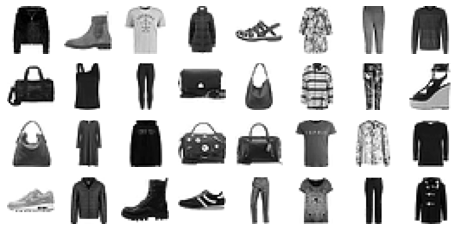

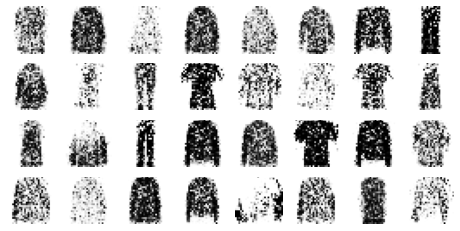

=================Epoch 2 finised==================


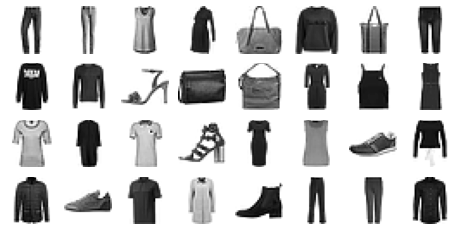

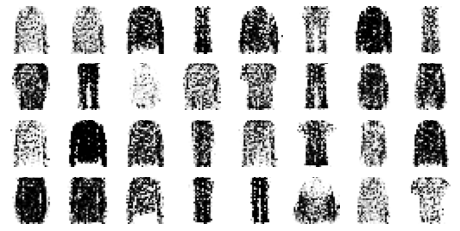

=================Epoch 3 finised==================


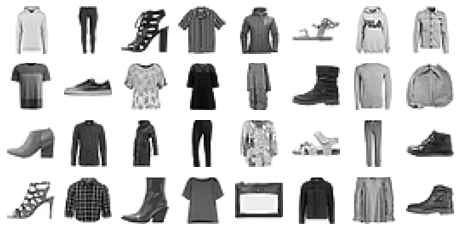

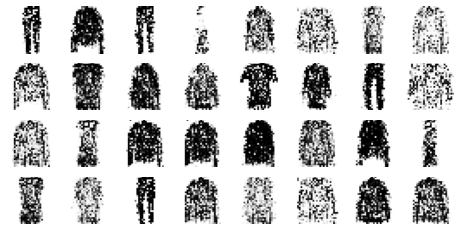

=================Epoch 4 finised==================


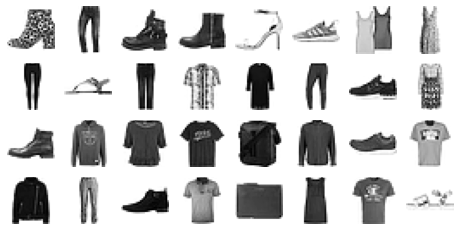

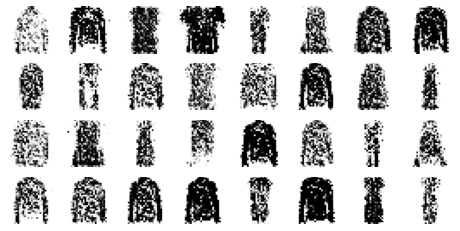

=================Epoch 5 finised==================


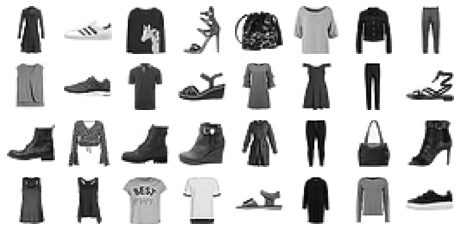

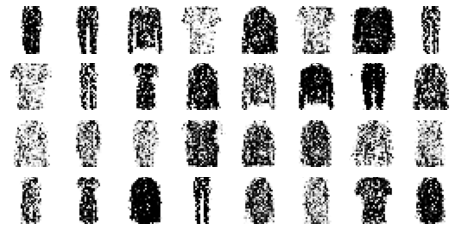

=================Epoch 6 finised==================


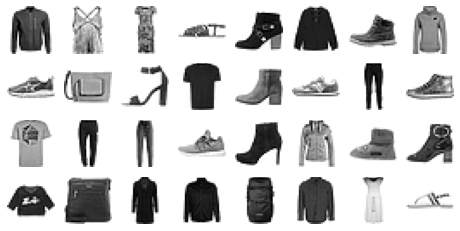

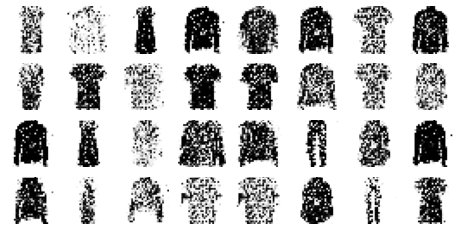

=================Epoch 7 finised==================


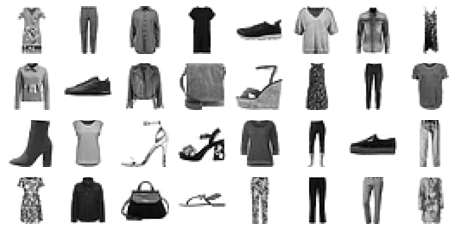

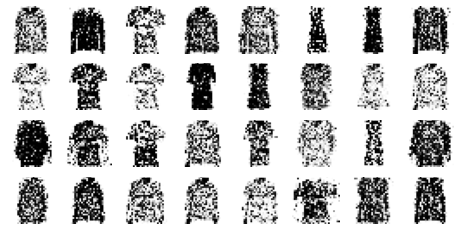

=================Epoch 8 finised==================


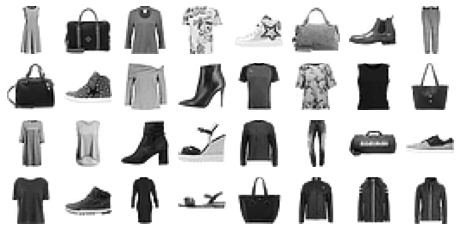

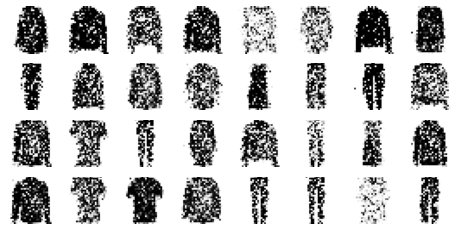

=================Epoch 9 finised==================


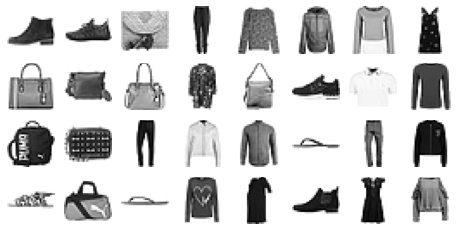

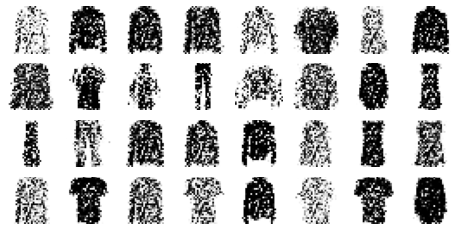

=================Epoch 10 finised=================


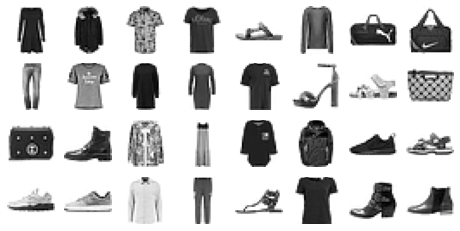

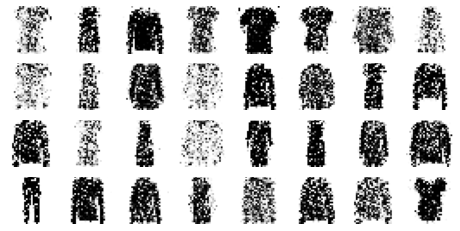

In [18]:
train_gan(gan, dataset, batch_size, codings_size)

# 一个大坑：

由于之前没加tf.config.experimental.set_memory_growth(physical_devices[i], True)，导致一直训练不出来，加上之后立马可以了。

# 2. 训练GAN的问题

通过上述训练结果可知，GAN具有一定的生成能力，但实际上生成图片的质量基本只能达到图上这种水平，无法再提高。并且有可能经过几个epoch之后发现gan忘记了之前学过的一些特征。

> 生成器和判别器在训练中类似于博弈，随着训练向前，最终会达到**纳什均衡**。在这种状态下，除非其它玩家更改策略，否则玩家不会改变自身策略。

GAN最大的问题是会出现模式坍塌（**mode collapse**）：当生成器对于某个类别的样本表现得更好（在判别器上）之后，生成器之后会尝试更多地产生这种模式的样本，慢慢地，生成器可能只会生成这种模式的样本，并慢慢丧失生成其它样本的能力，或者说**丧失多样性**。而当判别器能识别之后，生成器可能转而学习其它模式，直至达到纳什均衡，或者一直处于待收敛状态。

比如在上面的训练之中，生成器生成的样本基本上只有上衣、裤子和裙子，而图片一共有12类物品，其余的物品模式基本上被抛弃了。

另外，可能最终到达不了纳什均衡状态，生成器、判别器最后一直在一个范围内震荡。

综合，GAN的训练主要有两大问题：**训练不稳定**、**模式坍塌**。

# 3. DCGAN

目前，对于GAN仍有一些活跃的研究，产生了诸多GAN的变种，产生了一些在某些方面具有良好表现的模型。比如DCGAN（Deep Conbolutional GAN, 2016 ICLR）。

构建稳定的DCGAN有以下几方面**指导思想**：
1. 替换掉池化层，在判别器中用strided convolutions，在生成器中用transposed convolutions
2. 在生成器和判别器中都使用Batch Normalization，除了生成器输出和判别器输入
3. 不适用全连接层
4. 在生成器的所有层（输出层除外）使用ReLu激活，输出层使用tanh
5. 判别器的所有层都使用leaky ReLU激活

当然这些也不是金科玉律，只代表作者在某些方面的实践经验

# 3.1 数据导入和处理

沿用之前的数据和处理

In [37]:
batch_size = 32
x_train_dcgan = tf.reshape(x_train, (-1, 28, 28, 1)) * 2. - 1.
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan).shuffle(10000)
# 最后一个剩余batch剔除掉
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [38]:
# 高斯噪声的纬度
codings_size = 100

# 3.2 构建模型

In [39]:
generator = keras.models.Sequential([
    keras.layers.Dense(7*7*128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same',
                                activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding='same',
                                activation='tanh')
])

In [40]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding='same',
                       activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding='same',
                       activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
dcgan = keras.models.Sequential([generator, discriminator])

# 3.3 编译模型

In [42]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
dcgan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# 3.4 模型训练

训练同标准GAN

=================Epoch 1 finised==================


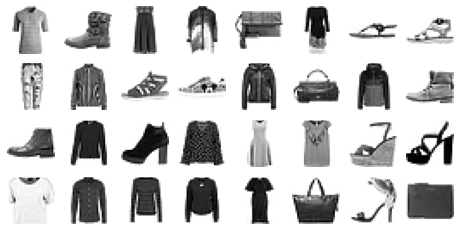

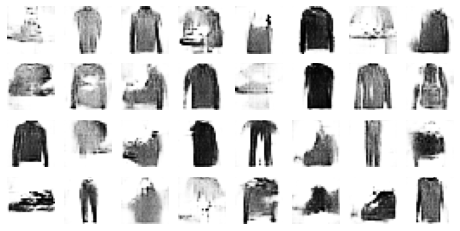

=================Epoch 2 finised==================


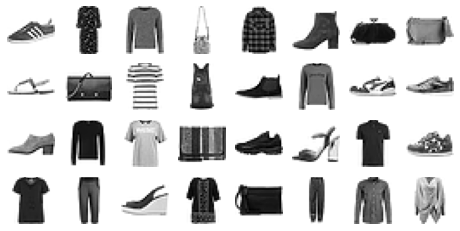

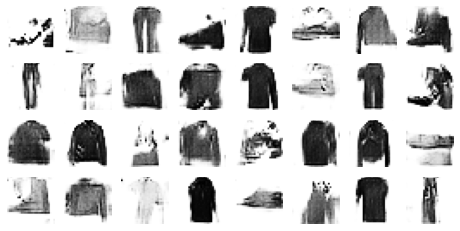

=================Epoch 3 finised==================


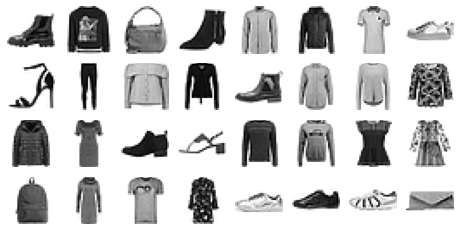

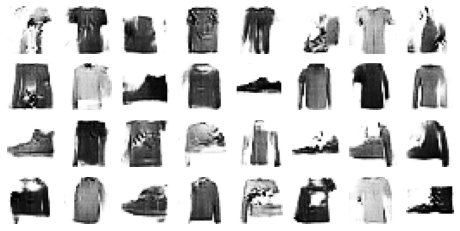

=================Epoch 4 finised==================


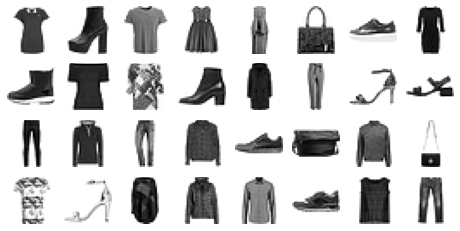

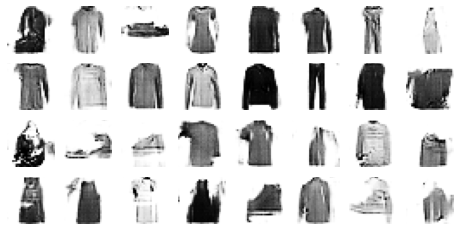

=================Epoch 5 finised==================


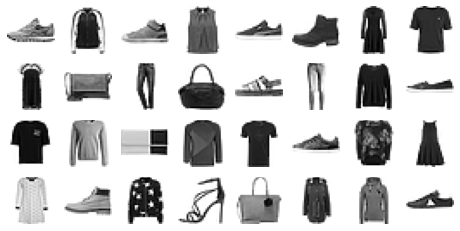

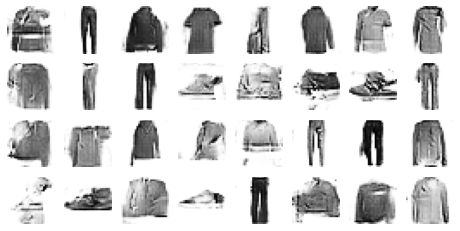

=================Epoch 6 finised==================


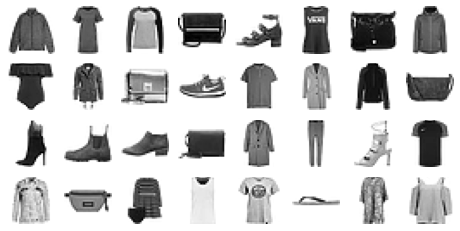

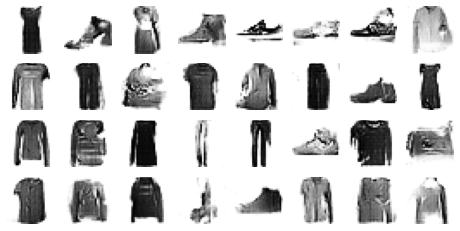

=================Epoch 7 finised==================


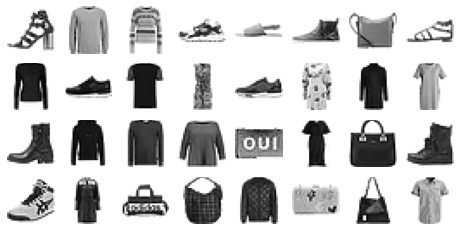

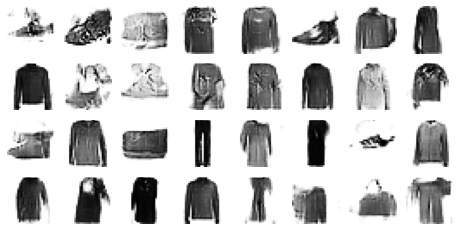

=================Epoch 8 finised==================


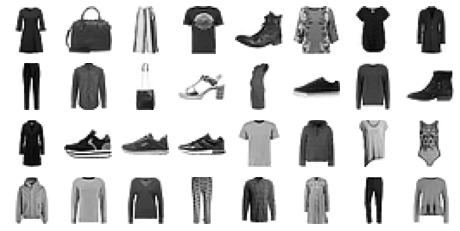

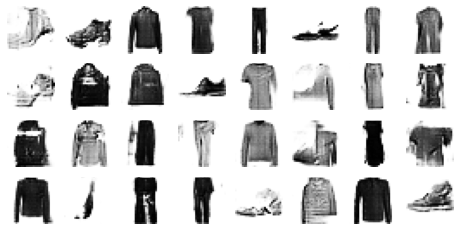

=================Epoch 9 finised==================


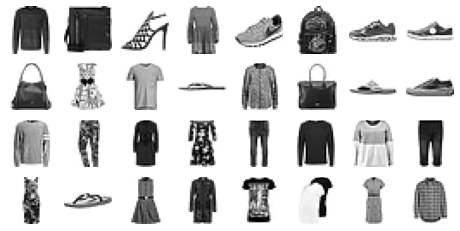

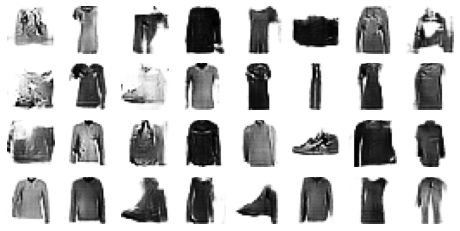

=================Epoch 10 finised=================


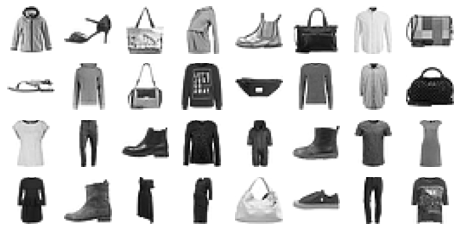

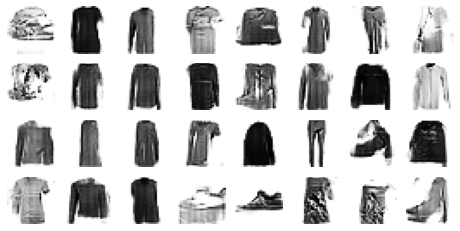

In [43]:
train_gan(dcgan, dataset, batch_size, codings_size)

可以发现，相对原始GAN，DCGAN的效果有了非常显著的进步

# 4. 其它GAN变种

- Progressively growing GAN[2018, ICLR]：先生成小图片，然后再逐步在生成器和判别器中加入卷积层生成越来越大的图片；同时介绍了其它提升多样性的方式：minibatch standard deviation layer, equalized learing rate, pixelwise normailzation layer
- StyleGAN[2018]。超分图像生成的一大先进技术，通过在生成器中使用风格迁移（style transfer）技术，使得生成样本和训练样本有相同的局部结构。判别器和损失函数不变。有两部分构成：mapping network，8层的MLP结构，将隐表示映射成向量，向量之后经过仿射变换，产生多个向量，这些向量控制图片不同维度的风格。简而言之，mapping network产生了多个表示风格特征的向量；synthesis network，负责生成图片。
- ...